## Complete Face Recognition Demo [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/likeshadows42/loki/blob/main/demos/GC_FR_complete_demo.ipynb)

This face recognition demonstrations shows the following steps in a complete face recognition system:
 - download and setup a small dataset for us to use as a 'test case'
 - how to create a representation database from a directory of images (or list of images)
 - how to verify each target image against our database (note that the verification of a target image against a set of many images - i.e. a database of images - is called recognition)
 - how to add the newly obtained representation of each target image to our existing database
 - download images from the web and run them through the verification / recognition process
 - test and compare performances during the verification step using (and not using) the Faiss library

**IMPORTANT NOTE:** Matplotlib is updated automatically to a suitable version, however, it requires a notebook restart. If the notebook detects the version is incorrect, it prints a message and kills itself. **This will look like a crash**, but it is not. Simply rerun the notebook and it should work.

### Imports & Setup

Loads the necessary modules, sets up important paths and defines all necessary functions, classes, constants, etc.

In [1]:
# Imports tensorflow first to check if gpus are running
import os
import matplotlib
from   time         import sleep

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Determines if this notebook if being run in colab
in_colab = 'google.colab' in str(get_ipython())

if in_colab:
    !pip install deepface
    !pip install faiss-gpu
    !pip install matplotlib --upgrade

if not matplotlib.__version__ == '3.5.1':
    print('\n'*2, '='*100, '\n' + 
      'MATPLOTLIB VERSION IS STILL OUTDATED - ' + 
      'KILLING THIS NOTEBOOK NOW (WILL LOOK LIKE A CRASH) - PLEASE RERUN IT!')
    sleep(1)
    os.kill(os.getpid(), 9)


In [40]:
import cv2
import faiss
import shutil
import random
import shelve
import pickle
import requests

import numpy                 as np
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg

from keras.preprocessing     import image
from deepface.detectors      import FaceDetector
from deepface.DeepFace       import build_model as build_verifier
from deepface.commons        import functions, distance as dst
from uuid                    import uuid4
from tqdm                    import tqdm
from copy                    import deepcopy
from PIL                     import Image
from io                      import BytesIO

from timeit                  import default_timer as timer

In [ ]:
# Stores the representation (embeddings) of a face image
class Representation():
    """
    Class to store the model-specific embeddings for an image.
    
    Attributes:
        After __init__:
            1. unique_id  - unique identifier number that represents a face
            2. image_name - image name
            3. image_fp   - image full path
            4. embeddings - model-specific vector representation of the face
        
    Methods:
        1. show_info() - prints the representation information in a condensed,
            easy-to-read form
    """
    def __init__(self, unique_id, image_name='', image_fp='', name_tag='',
                 region=[], embeddings={}):
        """
        Initializes the object with appropriate attributes
        """
        self.unique_id  = unique_id
        self.name_tag   = name_tag
        self.image_name = image_name
        self.image_fp   = image_fp
        self.region     = region
        self.embeddings = embeddings
        
    def show_info(self):
        """
        Shows detailed information about the Representation in a neat layout
        """
        print('Unique ID'.ljust(15) + f': {self.unique_id}',
              'Name'.ljust(15) + f': {self.name_tag}',
              'Image name'.ljust(15) + f': {self.image_name}',
              'Image full path'.ljust(15) + f': {self.image_fp}',
              'Face region'.ljust(15) + f': {self.region}', sep='\n')
        
        if self.embeddings: # embeddings dictionary is NOT empty
            print('Embeddings:')
            for k, v in self.embeddings.items():
                print(f'  > {k}: [{v[0]}, {v[1]}, {v[2]}, ... , {v[-1]}]'\
                    + f'(len={len(v)})')
                
        else:
            print('No embedding found!')

    def show_summary(self):
        """
        Shows summarized information about the Representation in a one-liner
        """
        print(f'UID: {self.unique_id}'.ljust(25),
              f'Name: {self.name_tag}'.ljust(15),
              f'Region: {self.region}'.ljust(15),
              f'FP: {self.image_fp}', sep=' | ')


In [39]:
# Setting up paths
API_DIR      = os.path.join(os.path.dirname(os.path.realpath("__file__")))
DST_ROOT_DIR = os.path.join(API_DIR     , 'data')
SVD_MDL_DIR  = os.path.join(API_DIR     , 'saved_models')
SVD_VRF_DIR  = os.path.join(SVD_MDL_DIR , 'verifiers')

directory_list       = [API_DIR, DST_ROOT_DIR, SVD_MDL_DIR, SVD_VRF_DIR]
directory_list_names = ['api root', 'dataset root', 's. models', 's. verifiers']

# Print path names
print('  -> Path names:')
for name, fp in zip(directory_list_names, directory_list):
    print(f'Directory {name}'.ljust(22), f': {fp}', sep='')
print('')

  -> Path names:
Directory api root    : /home/studio-lab-user/loki/api
Directory dataset root: /home/studio-lab-user/loki/api/data
Directory s. models   : /home/studio-lab-user/loki/api/saved_models
Directory s. verifiers: /home/studio-lab-user/loki/api/saved_models/verifiers



In [3]:
# NOTE: These functions were copied directly to the notebook to avoid conflicts
# and issues when importing from separate Python files. FastAPI seems to work
# with relative imports while IPYNP seems to work with absolute imports, so to
# avoid this issue alltogether, just keep the functions local to this demo.

# ______________________________________________________________________________
#                                   FUNCTIONS
# ------------------------------------------------------------------------------

def get_image_paths(root_path, file_types=('.jpg', '.png'), do_sort=True):
    """
    Gets the full paths of all 'file_types' files in the 'root_path' directory
    and its subdirectories. If the 'root_path' provided points to a file, this
    functions simply returns that path as a list with 1 element. The image path
    list is sorted if 'do_sort' flag is set to true (default).

    Inputs:
        1. root_path  - full path of a directory
        2. file_types - tuple containing strings of file extensions
            ([file_types=('.jpg', '.png')])
        3. do_sort    - boolean indicating if image path list should be sorted
            ([do_sort=True])

    Output:
        1. list containing full path of all files in the directory and its
            subdirectories

    Example call:
        ROOT_PATH = path/to/some/folder/dude
        all_images = get_image_paths(ROOT_PATH, file_types=('.png'))
    """
    # If the root path points to file, simply return it as a list with 1 element
    if os.path.isfile(root_path):
        return [root_path]
    
    # Gets all images in this root directory
    all_images = []
    for root, _junk, files in os.walk(root_path):
        # Processes files in the root directory - can be transformed into a list
        # comprehension but code might lose clarity
        for file in files:
            if file.lower().endswith(file_types):
                exact_path = os.path.join(root, file)
                all_images.append(exact_path)
    
    # Sort the image path list
    if do_sort:
        all_images.sort()

    return all_images

# ------------------------------------------------------------------------------

def create_dir(dir_path):
  """
  Creates a directory at the specified directory path 'dir_path' IF it does not
  exist. Returns a status of 0 is the directory was successfully created and 
  returns a status of 1 if a directory already exists.

  Inputs:
    1. dir_path - directory path of new directory.
    
  Outputs:
    1. status - 0 to indicate success (directory creation) or 1 to indicate
       failure (directory already exists)
    
  Signature:
    status = create_dir(dir_path)
  """
  # Create directory
  try:
    os.makedirs(dir_path)
    status = 0
  except FileExistsError:
    # Directory already exists
    status = 1

  return status

# ------------------------------------------------------------------------------

def saved_verifier_exists(verifier_name, save_dir=SVD_VRF_DIR):
    """
    Checks if a saved verifier exists with name 'verifier_name'. Does that by
    comparing the 'verifier_name' against the name of all files in 'save_dir'.
    
    Inputs:
        1. verifier_name - string with the name of the verifier.
        2. save_dir - string with the full path of the save directory
            ([save_dir=svd_vrf_dir]).
        
    Output:
        1. Boolean value indicating if saved verifier exists or not.
    
    Signature:
        verifier_exists = saved_verifier_exists(verifier_name,
                                                save_dir=svd_vrf_dir)
    """
    # Save directory provided is not a directory
    if not os.path.isdir(save_dir):
        return False
    
    # Otherwise, check if verifier name is in the names of files in the
    # 'save_dir' directory
    is_in = False
    for file_name in os.listdir(save_dir):
        is_in = is_in or verifier_name in file_name
    
    return is_in

# ------------------------------------------------------------------------------

def save_face_verifiers(verifiers, save_dir=SVD_VRF_DIR, show_prog_bar=True,
                        overwrite=False):
    """
    Saves all face verifier models specified in 'verifiers' using the 'shelve'
    (persistent storage) module. The models are saved in the 'save_dir'
    directory and each model is saved individually. Models that fail to save (or
    produces an error) are skipped. For each model that already exists, this
    function does not overwrite it unless the 'overwrite' flag is set to True.
    
    Inputs:
        1. verifiers - dictionary containing the build face verifier models.
        2. show_prog_bar - boolean that toggles the progress bar on or off.
        3. overwrite - boolean that indicates if the function should overwrite
                        any saved models.
                        
    Outputs:
        1. returns a status flag of True if any model fails to save (otherwise
            returns False)
    
    Signature:
        status = save_face_verifiers(verifiers, show_prog_bar=True,
                    overwrite=False)
    """
    # Checks if the save directory provided is a directory
    if not os.path.isdir(save_dir):
        return True
    
    # Creates the progress bar
    n_verifiers    = len(verifiers)
    disable_option = not show_prog_bar
    pbar           = tqdm(range(0, n_verifiers), desc='Saving verifiers',
                            disable = disable_option)
    
    # Loops through each verifier
    no_errors_flag = False # False means no errors
    for index, verifier_items in zip(pbar, verifiers.items()):
        # Gets the name of the verifier and the verifier object
        name     = verifier_items[0]
        verifier = verifier_items[1]
        
        if not saved_verifier_exists(name, save_dir=save_dir) or overwrite:
            try:
                # Creates the file's full path
                file_fp  = os.path.join(save_dir, name)
        
                # Opens a persistent dictionary, saves the model
                # as a dictionary then closes it
                with shelve.open(file_fp) as d:
                    d[name]  = verifier
            
            except Exception as excpt:
                no_errors_flag = True
            
    return no_errors_flag

# ------------------------------------------------------------------------------

def load_face_verifier(verifier_names, save_dir=SVD_VRF_DIR,
                        show_prog_bar=True, verbose=False):
    """
    Loads all face verifier models specified in 'verifier_names'. Alternatively,
    'all' can be passed as a 'verifier_name' to load all saved models. The
    models are loaded from the 'save_dir' directory.
      
    This function loads each model individually and skips any model that 
    fails to load (or produces an error).
    
    Inputs:
        1. verifier_name - string with the name of the face verifiers.
        2. save_dir      - string with the full path of the save directory
            ([save_dir='']).
        3. show_prog_bar - boolean that toggles the progress bar on or off.
                        
    Outputs:
        1. returns a status flag of True if any model fails to save (otherwise
            returns False)
            
    Signature:
        models = load_face_verifier(verifier_names, save_dir='',
                    show_prog_bar=True)
    """
    # Checks if the save directory provided is a directory
    if not os.path.isdir(save_dir):
        raise OSError(f'Save directory does not exist ({save_dir})!')
    
    # Ensures that the verifier_names is a list (even a single name is provided)
    if not isinstance(verifier_names, list):
        verifier_names = [verifier_names]
        
    # If 'all' was provided, use all model names
    if verifier_names[0].lower() == 'all':
        verifier_names = ['VGG-Face', 'OpenFace', 'Facenet', 'Facenet512',
                          'DeepFace', 'DeepID', 'ArcFace', 'Emotion', 'Age',
                          'Gender', 'Race']
    
    # Creates the progress bar
    n_verifiers    = len(verifier_names)
    disable_option = not show_prog_bar
    pbar           = tqdm(range(0, n_verifiers), desc='Loading verifiers',
                            disable = disable_option)
    
    models = {}
    for index, verifier_name in zip(pbar, verifier_names):       
        # Checks if the face verifier model exists
        if saved_verifier_exists(verifier_name, save_dir=save_dir):
            # Loads the model
            file_fp = os.path.join(save_dir, verifier_name)
            with shelve.open(file_fp) as model:
                if verbose:
                    print(f'[load_face_verifier] Loading model',
                          f'{verifier_name}: ', end='')
                try:
                    models[verifier_name] = model[verifier_name]
                    if verbose:
                        print('success!')
                except Exception as excpt:
                    if verbose:
                        print(f'failed! Reason: {excpt}\n',
                               '[load_face_verifier] Attempting to build',
                               ' & save model from scratch: ', sep='', end='')
                    try:
                        cur_model = build_verifier(verifier_name)
                        models[verifier_name] = cur_model
                        save_face_verifiers(cur_model, save_dir=save_dir,
                                            show_prog_bar=False, overwrite=True)
                        if verbose:
                            print('success!')
                    except Exception as excpt:
                        if verbose:
                            print(f'failed! Reason: {excpt}')
                                
        else:
            # Otherwise, tries to build model from scratch & save it
            if verbose:
                print(f'[load_face_verifier] Model {verifier_name} ',
                      'does not exist.', '\nAttempting to build & save model ',
                      'from scratch: ', sep='', end='')
            try:
                cur_model = build_verifier(verifier_name)
                models[verifier_name] = cur_model
                save_face_verifiers(cur_model, save_dir=save_dir,
                                    show_prog_bar=False, overwrite=False)
                if verbose:
                    print('success!')
            except Exception as excpt:
                if verbose:
                    print(f'failed! Reason: {excpt}')
            
    return models

# ------------------------------------------------------------------------------
        
def load_representation_db(file_path, verbose=False):
    """
    Loads a database (at 'file_path') containing representations of face images.
    The database is assumed to be a pickled Python object. The database is
    expected to be a list of Representation object (see help(Representation)
    for more information). If verbose is set to True, the loading processing is
    printed, with any errors being reported to the user.

    Inputs:
        1. file_path - string with file's full path
        2. verbose - flag indicating if the function should print information
            about the loading process and errors ([verbose=False])

    Output:
        1. database object (list of Representation objects)
    
    Signature:
        db = load_representation_db(file_path, verbose=False)
    """
    # Prints message
    if verbose:
        print('Opening database: ', end='')

    # Checks if path provided points to a valid database
    if os.path.isfile(file_path):
        # Try to open pickled database (list of objects)
        try:
            db = pickle.load(open(file_path, 'wb'))
            if verbose:
                print('success!')
        
        except (OSError, IOError) as e:
            if verbose:
                print(f'failed! Reason: {e}')
            db = []

    # If path does not point to a file, open an 'empty' database
    else:
        print(f'failed! Reason: database does not exist.')
        db = []

    return db
                
# ------------------------------------------------------------------------------

def load_representation_db(file_path, verbose=False):
    """
    Loads a database (at 'file_path') containing representations of face images.
    The database is assumed to be a pickled Python object. The database is
    expected to be a list of Representation object (see help(Representation)
    for more information). If verbose is set to True, the loading processing is
    printed, with any errors being reported to the user.

    Inputs:
        1. file_path - string with file's full path
        2. verbose - flag indicating if the function should print information
            about the loading process and errors ([verbose=False])

    Output:
        1. database object (list of Representation objects)
    
    Signature:
        db = load_representation_db(file_path, verbose=False)
    """
    # Prints message
    if verbose:
        print('Opening database: ', end='')

    # Checks if path provided points to a valid database
    if os.path.isfile(file_path):
        # Try to open pickled database (list of objects)
        try:
            db = pickle.load(open(file_path, 'wb'))
            if verbose:
                print('success!')
        
        except (OSError, IOError) as e:
            if verbose:
                print(f'failed! Reason: {e}')
            db = []

    # If path does not point to a file, open an 'empty' database
    else:
        print(f'failed! Reason: database does not exist.')
        db = []

    return db

# ------------------------------------------------------------------------------

def detect_faces(img_path, detector_backend = 'opencv', align = True,
                 return_type = 'both', face_detector = None):
    """
    Detects faces in an image (and optionally aligns them).
    
    Inputs:
        1. img_path - image path, base64 image or numpy array image
        2. detector_backend - string corresponding to detector ([opencv],
            ssd, dlib, mtcnn, retinaface, mediapipe).
        3. align - flag indicating if face should be aligned ([align=True]).
        4. return_type - string indicating if faces, regions or both should
            be returned ('faces', 'regions', ['both']).
            
    Outputs:
        If return_type='regions':
            Dictionary containing list of face detections. The face detections
            (or regions of interest - rois) are lists with the format
            [top-left x, top-left y, width, height]. The dictionary key is
            'regions'.
            
        If return_type='faces':
            Dictionary containing list of detected faces. Each detection is an
            image with 'target_size' size (the number of color channels is
            unchanged). The dictionary key is 'faces'.
            
        If return_type='both':
            Dictionary containing both of the above outputs: face detections and
            detected faces. The dictionary keys are 'faces' and 'regions'. 
    
    Signature:
        output = detect_faces(img_path, detector_backend = 'opencv',
                              align = True, return_type = 'both')
    """
    # Raises an error if return type is not 'faces', 'regions' or 'both'.
    # Otherwise, initializes lists.
    if return_type == 'faces' or return_type == 'regions' or \
        return_type == 'both':
        faces = []
        rois  = []
    else:
        raise ValueError("Return type should be 'faces', 'regions' or 'both'.")
    
    # Loads image. Image might be path, base64 or numpy array. Convert it to numpy
    # whatever it is.
    img = functions.load_image(img_path)

    # The detector is stored in a global variable in FaceDetector object.
    # This call should be completed very fast because it will return found in
    # memory and it will not build face detector model in each call (consider for
    # loops)
    if face_detector == None:
        face_detector = FaceDetector.build_model(detector_backend)
    detections = FaceDetector.detect_faces(face_detector, detector_backend,
                                            img, align)

    # Prints a warning and returns an empty dictionary and error if no faces were
    # found, otherwise processes faces & regions
    if len(detections) == 0:
        print('Face could not be detected or the image contains no faces.')

    else:
        # Loops through each face & region pair
        for face, roi in detections:

            # Only process images (faces) if the return type is 'faces' or 'both'
            if return_type == 'faces' or return_type == 'both':
                # Appends processed face
                faces.append(face)
    
            # Only process regions (rois) if the return type is 'regions' or 'both'
            if return_type == 'regions' or return_type == 'both':
                rois.append(roi)

  # ------------------------
  
    if return_type == 'faces':
        return {'faces':faces}
    elif return_type == 'regions':
        return {'regions':rois}
    else:
        assert return_type == 'both', "Return type should be 'both' here."
        return {'faces':faces, 'regions':rois}

# ------------------------------------------------------------------------------

def process_face(img_path, target_size=(224, 224), normalization='base',
                    grayscale=False):
    """
    Applies some processing to an image of a face:
        1. Loads the image from an image path, base64 encoding or numpy array
        2. If the 'grayscale' flag is True, converts the image to grayscale
        3. Resizes the image based on the smallest factor (target_size /
            dimension) and zero pads the resized image to match the target size.
        4. If for some reason the image is still not the target size, resizes
            the modified image once again.
        5. Normalizes the image based on the normalization option:
            a. 'base': do nothing
            b. 'raw': restore input in scale of [0, 255]
            c. 'Facenet': 'raw' then subtract image mean and divide by image
                    standard deviation
            d. 'Facenet2018': 'raw' then divide by 127.5 and subtract 1
            e. 'VGGFace': 'raw' then mean subtraction based on VGGFace1 training
                    data
            f. 'VGGFace2': 'raw' then mean subtraction based on VGGFace2
                    training data
            g. 'ArcFace': based on a reference study, 'raw', then pixels are
                    normalized by subtracting 127.5 then dividing by 128.

    Inputs:
        1. img_path - image path, base64 image or numpy array
        2. target_size - tuple containing desired X and Y dimensions
            ([target_size=(224, 224)])
        3. normalization - defines a type of normalization
            ([normalization='base'])
        4. grayscale - flag indicating if image should be converted to grayscale
            ([grayscale=False])

    Output:
        1. processed image as a numpy array

    Signature:
        face_image = process_face(img_path, target_size=(224, 224),
                                  normalization='base', grayscale=False)
    """
    # Loads the face image. Image might be path, base64 or numpy array. Convert
    # it to numpy whatever it is.
    face = functions.load_image(img_path)
    
    # Ensures that both dimensions are >0, otherwise raises error
    if face.shape[0] == 0 or face.shape[1] == 0:
        raise ValueError(f'Detected face shape is {face.shape}.')

    # Converts to grayscale if face is 
    if grayscale:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                
    # Resizes face
    if face.shape[0] > 0 and face.shape[1] > 0:
        factor_0 = target_size[0] / face.shape[0]
        factor_1 = target_size[1] / face.shape[1]
        factor   = min(factor_0, factor_1)

    dsize  = (int(face.shape[1] * factor), int(face.shape[0] * factor))
    face   = cv2.resize(face, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - face.shape[0]
    diff_1 = target_size[1] - face.shape[1]
                
    if not grayscale:
        # Put the base image in the middle of the padded image
        face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                             (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)),
                             'constant')
    else:
        face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                             (diff_1 // 2, diff_1 - diff_1 // 2)),
                             'constant')

    # Double check if target image is not still the same size with target.
    if face.shape[0:2] != target_size:
        face = cv2.resize(face, target_size)

    # Normalizing the image pixels
    if normalization == 'base':
        face  = image.img_to_array(face) #what this line doing? must?
        face  = np.expand_dims(face, axis = 0)
        face /= 255 # normalize input in [0, 1]
    else:
        face = functions.normalize_input(face, normalization=normalization)
    
    return face

# ------------------------------------------------------------------------------

def calc_cosine_similarity(A, B):
    """
    Calculates the cosine similarity metric between matrices A and B. If A is a
    vector, it is converted into a matrix so that the cosine metric can be
    calculated normally.

    Inputs:
        1. A - N x M matrix with N embeddings with M elements
        2. A - I x M matrix with I embeddings with M elements

    Outputs:
        1. matrix of cosine similarity metric between A and B

    Signature:
        csm = calc_cosine_similarity(A, B)
    """
    if A.ndim == 1:
        A = A[np.newaxis, :]

    num = np.dot(A, B.T)
    p1  = np.sqrt(np.sum(A**2, axis=1))[:, np.newaxis]
    p2  = np.sqrt(np.sum(B**2, axis=1))[np.newaxis, :]
    return 1 - (num / (p1 * p2))

# ------------------------------------------------------------------------------

def calc_euclidean_similarity(A, B, l2_normalize=False):
    """
    Calculates the Euclidean similarity metric between matrices A and B. If A is
    a vector, it is converted into a matrix by repeating (and stacking) it
    horizontally until it has the correct dimensions. If 'l2_normalize' is set
    to True, then the function applies L2 normalization to the inputs before
    calculating the Euclidean similarity (distance).

    Inputs:
        1. A - N x M matrix with N embeddings with M elements
        2. A - I x M matrix with I embeddings with M elements
        3. l2_normalize - boolean to indicate if the inputs should be L2
            normalized before calculating the similarity ([l2_normalize=True])

    Outputs:
        1. matrix of Euclidean similarity metric between A and B

    Signature:
        edm = calc_euclidean_similarity(A, B, l2_normalize=False)
    """
    # Applies l2 normalization to the inputs if necessary
    if l2_normalize:
        if A.ndim == 1:
            A = A / np.sqrt(np.sum(np.multiply(A, A)))
        else:
            A = np.transpose(A.T / np.linalg.norm(A, axis=1))

        if B.ndim == 1:
            B = B / np.sqrt(np.sum(np.multiply(B, B)))
        else:
            B = np.transpose(B.T / np.linalg.norm(B, axis=1))

    # 'Repeats vertically' vector A until it is a matrix with appropriate
    # dimensions 
    if A.ndim == 1:
        A = np.tile(A, (B.shape[0], 1))

    # Calcultes and returns the Euclidean distance
    return np.sqrt(np.sum((A - B) * (A - B), axis=1))

# ------------------------------------------------------------------------------

def calc_similarity(tgt_embd, embds, metric='cosine', model_name='VGG-Face',
                    threshold=-1):
    """
    Calculates the similarity (distance) between both embeddings ('tgt_embd'
    and 'embds') using the 'metric' distance metric. If the 'threshold' < 0 then
    it is automatically determined based on the 'model_name' provided. If a 
    custom threshold is specified, then the 'model_name' input is unused.

    Note that 'embds' can be a N x M matrix (N embeddings each with M elements)
    and 'tgt_embd' can only be a 1 x M embedding.

    Inputs:
        1. tgt_embd - 1-D numpy array containing the embedding.
        2. embds - 1-D or 2-D numpy array containing the embedding(s).
        3. metric - string specifying the distance metric to be used
            (['cosine'], 'euclidean', 'l2_euclidean').
        4. model_name - string specifying the model name (['VGG-Face']).
        5. threshold - if a negative float is provided, then the threshold is
            calculated automatically based on the model name provided.
            Otherwise, the threshold provided is used ([threshold=-1]).

    Output:
        1. dictionary containing the indexes of matches (key: idxs), the
            threshold value used (key: threshold) and the distances (using the
            specified metric) of the matches (key: distances). Note that if no
            match is found, then the 'indexes' will have a length of zero (i.e.
            will be empty).
    
    Signature:
        similarity_obj = calc_similarity(tgt_embd, embds, metric='cosine',
                                         model_name='VGG-Face', threshold=-1)
    """
    # Calculates the distance based on the metric provided, otherwise raises a
    # value error
    if metric == 'cosine':
        distances = calc_cosine_similarity(tgt_embd, embds)
    elif metric == 'euclidean':
        distances = calc_euclidean_similarity(tgt_embd, embds)
    elif metric == 'euclidean_l2':
        distances = calc_euclidean_similarity(tgt_embd, embds,
                                              l2_normalize=True)
    else:
        raise ValueError(f'Invalid metric passed: {metric}')

    # If threshold is negative, determine threshold automatically based on the
    # model name and distance metric
    if threshold < 0:
        threshold = dst.findThreshold(model_name, metric)
    
    # Processes distances
    distances = distances.flatten() # flattens into 1-D array

    # Makes a decision
    decision  = (distances <= threshold)
    idxs      = np.where(decision)[0]

    # Determines the corresponding distances of each match (decision==True)
    dists = []
    j     = 0
    for i in range(len(distances)):
        if i in idxs:
            dists.append(distances[i])
            j += 1
        
        if j == len(idxs):
            break

    # Sort the indexes by smallest distance
    srt_dists = []
    srt_idxs  = []
    for dist, idx in sorted(zip(dists, idxs)):
        srt_idxs.append(idx)
        srt_dists.append(dist)

    return {'idxs': np.array(srt_idxs),
            'threshold': threshold,
            'distances': np.array(srt_dists)}

# ------------------------------------------------------------------------------

def calc_embedding(img_path, verifier_models, detector_name='opencv',
                    align=True, verifier_names='VGG-Face',
                    normalization='base'):
    """
    TODO: ADD DESCRIPTION
    """
    # Converts verifier names into a list if it is a single entry
    if not isinstance(verifier_names, list):
        verifier_names = [verifier_names]

    # Tries to detect faces & align:
    try:
        output = detect_faces(img_path, detector_backend=detector_name,
                                align=align, return_type='both',
                                face_detector=None)
    except:
        print('[calc_embedding] Error: face detection failed!')
        return ([], {})

    # TODO: MAKE THE FUNCTION ACCEPT MULTIPLE FACES IN ONE IMAGE
    # Since we assume there is only 1 face (and region):
    face   = output['faces'][0]
    region = output['regions'][0]

    # For each verifier model provided
    embeddings={}
    for verifier_name in verifier_names:
        # Gets the current verifier model
        model = verifier_models[verifier_name]

        # Determine target size
        input_x, input_y = functions.find_input_shape(model)

        # Process face
        processed_face = process_face(face, target_size=(input_x, input_y),
                                normalization=normalization, grayscale=False)

        # Calculate embeddings
        embeddings[verifier_name] = model.predict(processed_face)[0]

    return (region, embeddings)

# ------------------------------------------------------------------------------

def create_new_representation(img_path, region, embeddings, tag='', uid='',
                                ignore_taglist=['--', '---']):

    # If Unique IDentifier (UID) is not provided, generate one
    if len(uid) == 0 or uid == '':
        uid = uuid4()

    # If tag is in the ignore taglist, then it is considered as a "ignore" tag
    if tag in ignore_taglist:
        tag = ''

    # Returns the new representation
    return Representation(uid, image_name=img_path.split('/')[-1], 
                          image_fp=img_path, name_tag=tag, region=region,
                          embeddings=embeddings)

# ------------------------------------------------------------------------------

def get_embeddings_as_array(db, verifier_name):
    """
    Gets all of the embeddings for a given 'verifier_name' from the database
    'db' and returns it as a N x M numpy array where N is the number of
    embeddings and M is the number of elements of each embeddings.

    Inputs:
        1. db - database object (list of Representation objects)
        2. verifier_name - name of verifier

    Output:
        1. N x M numpy array where each row corresponds to a face image's
            embedding

    Signature:
        embeddings = get_embeddings_as_array(db, verifier_name)
    """
    embeddings = [] # initializes empty list
    for rep in db:
        embeddings.append(rep.embeddings[verifier_name])

    return np.array(embeddings)

# ------------------------------------------------------------------------------

def person_name_lookup(img_paths):
    """
    
    """
    name_list = []
    for pth in img_paths:
        cur_num = int(pth.split('/')[-1][3:5])

        if cur_num   in [ 1,  2,  4,  5,  6,  7, 10, 11]:   # Angelina Jolie
            name_list.append('Angelina Jolie')
        
        elif cur_num in [ 3, 12, 53, 54, 55, 56]:           # Jennifer Aniston
            name_list.append('Jennifer Aniston')

        elif cur_num in [ 8,  9, 47, 48, 49, 50, 51]:       # Scarlett Johansson
            name_list.append('Scarlett Johansson')

        elif cur_num in [13, 14, 15, 57, 58]:               # Mark Zuckerberg
            name_list.append('Mark Zuckerberg')

        elif cur_num in [16, 17, 59, 61, 62]:               # Jack Dorsey
            name_list.append('Jack Dorsey')

        elif cur_num in [18, 19, 67]:                       # Elon Musk
            name_list.append('Elon Musk')

        elif cur_num in [20, 21]:                           # Jeff Bezos
            name_list.append('Jeff Bezos')

        elif cur_num in [22, 23]:                           # Marissa Meyer
            name_list.append('Marissa Meyer')

        elif cur_num in [24, 25]:                           # Sundar Pichai
            name_list.append('Sundar Pichai')
        
        elif cur_num in [26, 27, 28, 42, 43, 44, 45, 46]:   # Katy Perry
            name_list.append('Katy Perry')

        elif cur_num in [29, 30, 31, 32, 33]:               # Matt Damon
            name_list.append('Matt Damon')

        elif cur_num in [34, 35, 36, 37]:                   # Leonardo DiCaprio
            name_list.append('Leonardo DiCaprio')

        elif cur_num in [38, 39, 40, 41]:                   # George Clooney
            name_list.append('George Clooney')

        else:
            name_list.append('')                            # missing name

    return name_list

# ------------------------------------------------------------------------------

def create_reps_from_dir(img_dir, verifier_models, detector_name='opencv',
                    align=True, verifier_names='VGG-Face', show_prog_bar=True,
                    normalization='base', tags=[], uids=[], skip_get_imgs=False,
                    verbose=False):
    """
    Creates a representations from images in a directory 'img_dir'. The
    representations are returned in a list, and the list of representations. If
    tags and/or unique identifiers (uids) are provided, make sure that they 
    correspond to the sorted (ascending) image names contained in 'img_dir'.

    Inputs:
        1. img_dir - string with the full path to the directory containing the
            images.

        2. verifier_models - dictionary containing model name (key) and model
            object (value).

        3. detector_name - string with the face detector name ([opencv], ssd,
            dlib, mtcnn, retinaface).
        
        4. align - boolean flag to indicate if face images should be aligned.
            Improves face recognition performance at the cost of some speed
            ([True], False).

        5. verifier_names - string with the face verifier name ([VGG-Face],
            OpenFace, Facenet, Facenet512, DeepFace, DeepID, ArcFace).

        6. show_prog_bar - boolean that toggle the progress bar on or off
            ([True], False).

        7. normalization - normalizes the face image and may increase face
            recognition performance depending on the normalization type and the
            face verifier model ([base], raw, Facenet, Facenet2018, VGGFace,
            VGGFace2, ArcFace).

        8. tags - list of strings where each string corresponds to a tag for the
            i-th image, i.e. tags[0] is the tag for the first image in the
            sorted list of image name obtain from 'img_dir' directory. If an
            empty list is provided, this is skipped during the representation
            creation process ([tags=[]]).

        9. uids - list of strings where each string corresponds to a unique
            identifier (UID) for the i-th image, i.e. uids[0] is the UID for the
            first image in the sorted list of image name obtain from 'img_dir'
            directory. If an empty list is provided, a UID is created for each
            image during the representation creation process ([uids=[]]).

        10. skip_get_imgs - boolean to skip getting the image paths from the
            directory. This should be set to True if a list of image paths is
            provided as 'img_dir' as opposed to a directory
            ([skip_get_imgs=False]).
            
        11. verbose - boolean to toggle function warnings and other messages
            ([True], False).

        Note: the 'tags' and 'uids' lists (inputs 8 and 9) must have the same
        number of elements (length) and must match the number of images in
        'img_dir'. If not, these inputs will be treated as empty lists (i.e.
        ignored).

    Outputs:
        1. list of Representation objects. For more information about the
            Representation class attributes and methods, use
            help(Representation)

    Signature:
        rep_db = create_reps_from_dir(img_dir, verifier_models, 
                        detector_name='opencv', align=True,
                        verifier_names='VGG-Face', show_prog_bar=True,
                        normalization='base', tags=[], uids=[], verbose=False)
    """
    # Initializes skip flags and database (list of Representation objects)
    skip_tag = False
    skip_uid = False
    rep_db   = []
    
    # Assuming img_dir is a directory containing images
    if not skip_get_imgs:
        img_paths = get_image_paths(img_dir)
        img_paths.sort()
    else:
        img_paths = img_dir

    # No images found, return empty database
    if len(img_paths) == 0:
        return []

    # If tags list does not have the same number of elements as the images (i.e.
    # 1 tag per image), ignore it
    if len(tags) != len(img_paths):
        if verbose:
            print('[create_reps_from_dir] Number of tags and image paths',
                  'must match. Ignoring tags list.')
        skip_tag = True

    # If uids list does not have the same number of elements as the images (i.e.
    # 1 UID per image), ignore it
    if len(uids) != len(img_paths):
        if verbose:
            print('[create_reps_from_dir] Number of UIDs and image paths',
                  'must match. Ignoring uids list.')
        skip_uid = True

    # Creates the progress bar
    n_imgs  = len(img_paths)
    disable = not show_prog_bar
    pbar    = tqdm(range(0, n_imgs), desc='Creating representations',
                    disable=disable)

    # Loops through each image in the 'img_dir' directory
    for pb_idx, i, img_path in zip(pbar, range(0, n_imgs), img_paths):
        # Calculate the face image embedding
        region, embeddings = calc_embedding(img_path, verifier_models,
                                            align=align,
                                            detector_name=detector_name, 
                                            verifier_names=verifier_names,
                                            normalization=normalization)

        # Determines if tag was provided and should be used when creating this
        # representation
        if skip_tag:
            tag = ''
        else:
            tag = tags[i]

        # Determines if UID was provided and should be used when creating this
        # representation
        if skip_uid:
            uid = ''
        else:
            uid = uids[i]

        # Create a new representation and adds it to the database
        rep_db.append(create_new_representation(img_path, region, embeddings,
                                                tag=tag, uid=uid))

    # Return representation database
    return rep_db

# ------------------------------------------------------------------------------

def find_image_in_db(img_path, db, shortcut=None):
    """
    Finds the corresponding Representation in the database 'db'. Uses the
    image's name obtained from its full path ('img_path') to match the
    Representation to the image. An optional dictionary ('shortcut') can be
    provided where each letter corresponds to an index to speed up the search.
    Consider a sorted database where the first image with a name starting with
    a 'g' is at position 156. Then a shortcut dictionary with the key/value pair
    'g':155 will ensure this function starts at the position 156 and wont waste
    time previous database entries.

    Inputs:
        1. img_path - image path, base64 image or numpy array
        2. db - database object (list of Representation objects)
        3. shortcut - optional dictionary with letter/index key/value pairs
            ([shortcut=None])

    Output:
        1. tuple containing the matching Representation object and the index
            corresponding to that object in the database (i.e. output
            representation == database[output index]). If no match is found,
            both representation and index are returned as empty lists. If
            multiple entries are found, multiple Representations and indexs are
            returned as lists.
    """
    rep_objs = [] # empty representation object
    rep_idxs = [] # no matching index

    # Database is empty
    if len(db) == 0:
        pass # do nothing

    # 'shortcut' dictionary is provided
    elif not shortcut == None:
        # Get image name
        img_name = img_path.split('/')[-1].lower()
        idx      = shortcut[img_name[0]]

        # 
        for i, rep in enumerate(db[idx::]):
            if img_name.lower() == rep.image_name:
                rep_objs.append(rep)
                rep_idxs.append(i + idx)

    # 'shortcut' dictionary is not provided
    else:
        # Get image name
        img_name = img_path.split('/')[-1].lower()

        # 
        for i, rep in enumerate(db):
            if img_name.lower() == rep.image_name:
                rep_objs.append(rep)
                rep_idxs.append(i)

    return (rep_objs, rep_idxs)

# ------------------------------------------------------------------------------

def create_faiss_index(embeddings, metric='cosine'):
    """
    Create faiss indexes from 'embeddings'. Embeddings are expected to be a
    N x M numpy array with N embeddings each with M elements.

    Inputs:
        1. embeddings - N x M numpy array
        2. metric - string specifying the distance/similarity metric ([cosine],
            euclidean, euclidean_l2)

    Output:
        1. index object with embeddings added

    Signature:
        index = create_faiss_index(embeddings, metric='cosine')
    """
    # Create the appropriate index based on the distance metric provided. If the
    # distance metric provided is not valid (not cosine, euclidean or
    # euclidean_l2), an error is raised.
    if metric == 'cosine':
        index = faiss.IndexFlatIP(embeddings.shape[1])
    elif metric in ['euclidean', 'euclidean_l2']:
        index = faiss.IndexFlatL2(embeddings.shape[1])
    else:
        raise ValueError(f'{metric} is an invalid metric!',
                          'Expected cosine, euclidean or euclidean_l2.',
                          sep='\n')
    
    # Applies L2 normalization in the cases of cosine or euclidean_l2 metrics
    if metric in ['cosine', 'euclidean_l2']:
        embeddings = dst.l2_normalize(embeddings)

    # Adds the embeddings to the index object
    index.add(embeddings)

    return index

# ------------------------------------------------------------------------------

def verify_with_faiss(target_embd, index, db, top_x=3, model_name='VGG-Face',
                      metric='cosine', threshold=-1):
    """
    Uses the Faiss library to speed up the verification process. The 'index'
    object is a faiss-specific object with the embeddings of the whole database
    'db'. Using faiss fast search, the 'top_x' nearest neighbour embeddings are
    obtained and are used to create a subset of the original database.

    The similarity (and matches) are then calculated using the subset database,
    which is only 'top_x' large. Note that the speed gains are more noticeable
    for larger databases and small values of 'top_x'. Also note that if there
    are more than 'top_x' matches, then only 'top_x' will be returned.

    Finally, if top_x = 1 then this function returns the nearest neighbour match
    and the 'model_name' and 'threshold' parameters have no effect. In this
    case, the threshold value in the output dictionary will be equal to -1 to
    indicate it has not been used.

    Inputs:
        1. target_embd - 1-D numpy array containing the embedding.
        2. index - faiss-specific index object. Use 'load_faiss_indexes'
                function to create it.
        3. db - database (list of Representation objects)
        4. top_x - natural number indicating the number of nearest neighbours to
                filter the database ([top_x=3])
        5. model_name - string specifying the model name (['VGG-Face']).
        6. metric - string specifying the distance metric to be used
                (['cosine'], 'euclidean', 'l2_euclidean').
        7. threshold - if a negative float is provided, then the threshold is
                calculated automatically based on the model name provided.
                Otherwise, the threshold provided is used ([threshold=-1]).
    
    Output:
        1. dictionary containing the indexes of matches (key: idxs), the
            threshold value used (key: threshold) and the distances calculated
            using the specified metric (key: distances). Note that if no match
            is found, then the 'indexes' will have a length of zero (i.e. will
            be empty). The indexes and distances are sorted so that the first
            index has the smallest distance, the second index has the second
            smallest distance, and so on.

    Signature:
        similarity_obj = verify_with_faiss(target_embd, index, db, top_x=3,
                                    model_name='VGG-Face', metric='cosine',
                                    threshold=-1)
    """
    # Obtains the 'top_x' nearest neighbours
    distances, neighbors = index.search(target_embd, top_x)

    # If top_x is 1 then simply return the closest neighbour
    if top_x == 1:
        similarity_obj['idxs']      = np.array(neighbors[0], dtype=int)
        similarity_obj['threshold'] = -1
        similarity_obj['distances'] = distances
        return similarity_obj

    # Obtains the embeddings for the 'filtered' (top_x) representations
    idxs          = []
    filtered_reps = []
    for i in np.array(neighbors[0], dtype=int):
        idxs.append(i)
        filtered_reps.append(db[i])

    embds = get_embeddings_as_array(filtered_reps, model_name)

    # Calculates the matches to the target embedding (from the top_x filtered
    # set of representations)
    similarity_obj = calc_similarity(target_embd, embds, metric=metric,
                                     model_name=model_name, threshold=threshold)

    # Note that the indexes returned in the similarity object refer to the
    # filtered representations. So the correct indexes (from the original
    # database) are actually the idxs[similarity_obj['idxs']]
    similarity_obj['idxs'] = [idxs[i] for i in similarity_obj['idxs']]

    return similarity_obj

# ------------------------------------------------------------------------------


In [4]:
# All detectors and verifiers
DETECTOR_NAMES = ('opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface')
VERIFIER_NAMES = ('VGG-Face', 'OpenFace', 'Facenet', 'Facenet512', 'DeepFace',
                  'DeepID', 'Dlib', 'ArcFace', 'Emotion', 'Age', 'Gender',
                  'Race')

# Directories & paths initialization
print('  -> Directory creation:')
for directory in directory_list:
    print(f'Creating {directory} directory: ', end='')
    
    if create_dir(directory):
        print('directory exists. Continuing...')
    else:
        print('success.')
print('')

  -> Directory creation:
Creating /home/studio-lab-user/loki/api directory: directory exists. Continuing...
Creating /home/studio-lab-user/loki/api/data directory: directory exists. Continuing...
Creating /home/studio-lab-user/loki/api/data/raw directory: directory exists. Continuing...
Creating /home/studio-lab-user/loki/api/data/targets directory: directory exists. Continuing...
Creating /home/studio-lab-user/loki/api/data/database directory: directory exists. Continuing...
Creating /home/studio-lab-user/loki/api/saved_models directory: directory exists. Continuing...
Creating /home/studio-lab-user/loki/api/saved_models/verifiers directory: directory exists. Continuing...



## Start of Demo

We will start this demo by setting up some parameters.

In [5]:
chosen_model   = 'ArcFace'     # this will be our face verifier model (its state-of-the-art)
chosen_backend = 'retinaface'  # this will be our face detector model (also state-of-the-art)
align          = True          # aligning faces improves around 1-2% recognition accuracy
normalization  = 'base'        # we will use base but 'ArcFace' normalization should be better
metric         = 'cosine'      # the Euclidean_L2 norm might be slightly better but we'll stick to the classic
use_faiss      = False         # uses the Faiss library for verification - unfortunately, does not seem to improve performance
top_x          = 10            # return top 10 nearest neighbours (for use with Faiss)
threshold      = -1            # -1 means automatically get threshold based on chosen model & metric

# Paths
stored_imgs_path  = '/' + os.path.join(*(API_DIR.split('/')[:-1]), 'dataset') # path where images are stored
db_path           = '' # no database exists - we will create it from scratch
svd_verifier_path = SVD_VRF_DIR # path where pre-built face verifier models are stored

# Splits
db_split  = [ 5,  6,  8, 11, 12, 14, 17, 19, 20, 23, 24, 26, 27, 28, 29, 30,\
             32, 35, 36, 38, 41, 51, 52, 55, 60, 61]                           # database split
tgt_split = [ 1,  2,  3,  4,  7,  9, 10, 13, 15, 16, 18, 21, 22, 25, 31, 33,\
             34, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54,\
             56, 57, 58, 59]                                                   # targets split

# Web images' URLs:
img_urls = ['https://media.wired.com/photos/5fb4493f941d009a0c07f3be/master/pass/Business-Marissa-Meyer-h_15074779.jpg',          # Marissa Meyer
            'https://c.files.bbci.co.uk/58A5/production/_119239622_976_jeff_bezos_getty.jpg',                                     # Jeff Bezos
            'https://media.wired.com/photos/5ec70372c96258473f891964/16:9/w_2399,h_1349,c_limit/Biz-pichai-h_15151797.jpg',       # Sundar Pichai
            'https://upload.wikimedia.org/wikipedia/commons/8/89/Sundar_Pichai_%28cropped1%29.jpg',                               # Sundar Pichai
            'https://assets.vogue.com/photos/60246b20b04179f82a56d012/3:4/w_1446,h_1928,c_limit/GettyImages-462239140%20(1).jpg', # Jennifer Aniston
            'https://pbs.twimg.com/profile_images/1392465354622791687/w_KwtKcE_400x400.jpg']                                      # Katy Perry

web_img_tags = ['Marissa Meyer', 'Jeff Bezos', 'Sundar Pichai', 'Sundar Pichai',
                'Jennifer Aniston', 'Katy Perry']


We will start this demo by downloading a small dataset to test the FR system. This dataset is provided in the deepface repository and contains varying numbers of images of 13 different celebraties / important people.

Then, the dataset is divided into a database set and a target set. The database set will be used to create an initial database to run the recognition of the target set images against.

In [6]:
# Code to download the dataset in case 'dataset_path' does not exist
in_colab = 'google.colab' in str(get_ipython())
if not os.path.isdir(stored_imgs_path) and in_colab:
    # Clones the repo that contains the dataset
    !git clone https://github.com/serengil/deepface/
    
    # Cleans up any old, leftover dataset
    try:
        shutil.rmtree('dataset')
    except:
        pass
    
    # Moves the dataset directory to outside the repo
    try:
        shutil.move('deepface/tests/dataset', 'dataset')
    except:
        pass

    # Deletes the rest of the repo - we only need the dataset
    try:
        shutil.rmtree('deepface')
    except:
        pass
    
    # Sets the correct path to the images
    stored_imgs_path = 'dataset'
    
# Process dataset for convenience
assert(os.path.isdir(stored_imgs_path))

# Renames the images, zero padding numbers if necessary
for file in os.listdir(stored_imgs_path):
    if file.split('.')[-1] in ['jpg', 'png']:
        # Determines the current file's number and creates the old and new full paths
        # The new full path is similar to the old one, except that the image numbers
        # are 0 padded (i.e. img1.jpg -> img01.jpg)
        file_num    = int(file.split('.')[0][3::])
        old_file_fp = os.path.join(stored_imgs_path, file)
        new_file_fp = os.path.join(stored_imgs_path, f'img{file_num:02d}.jpg')

        # Renames the file
        os.rename(old_file_fp, new_file_fp)



In [7]:
# Obtain the database and target splits' image paths & tags
all_imgs = get_image_paths(stored_imgs_path)   # gets all image paths
all_tags = person_name_lookup(all_imgs)        # gets the tag for each image

db_imgs  = [all_imgs[i-1] for i in db_split]   # gets all database images
tgt_imgs = [all_imgs[i-1] for i in tgt_split]  # gets all target images

db_tags  = [all_tags[i-1] for i in db_split]   # gets all database tags
#tgt_tags = [all_tags[i-1] for i in tgt_split]  # gets all target tags

Now we will load all the relevant face verifier models. To keep things simple, we will only use one.

In [8]:
# Loading just the ArcFace model as this model will be used throughout this demo
models = load_face_verifier([chosen_model], save_dir=svd_verifier_path,
                            show_prog_bar=False, verbose=True)

[load_face_verifier] Loading model ArcFace: success!


Now, we will create the database from the *'db_imgs'* image set.

In [9]:
# Creates the representation database from the image paths
rep_db = create_reps_from_dir(db_imgs, models, detector_name=chosen_backend,
                align=align, verifier_names=chosen_model, show_prog_bar=True,
                normalization=normalization, tags=db_tags, uids=[],
                skip_get_imgs=True, verbose=False)

# 
print('\nCreating faiss indexes for faster search: ', end='')
embds  = get_embeddings_as_array(rep_db, chosen_model)
findex = create_faiss_index(embds, metric=metric)
print('done!\n')

# - Print database summary
for i in range(len(rep_db)):
    print(f'Tag: {rep_db[i].name_tag}'.ljust(25),
          f'Path: {rep_db[i].image_fp}',
          f'UID: {rep_db[i].unique_id}', sep='  |  ')

Creating representations: 100%|██████████| 26/26 [01:08<00:00,  2.65s/it]


Creating faiss indexes for faster search: done!

Tag: Jennifer Aniston      |  Path: /home/studio-lab-user/loki/dataset/img03.jpg  |  UID: c263b0ce-f8fb-4eee-909e-6a1d1ff8c1b4
Tag: Angelina Jolie        |  Path: /home/studio-lab-user/loki/dataset/img04.jpg  |  UID: 12f8f7f9-230a-4c22-a9cb-d94c9ba559c5
Tag: Angelina Jolie        |  Path: /home/studio-lab-user/loki/dataset/img06.jpg  |  UID: 4763dd04-1323-4ab2-be9e-52f3ef4c7dd5
Tag: Scarlett Johansson    |  Path: /home/studio-lab-user/loki/dataset/img09.jpg  |  UID: 11aaddd4-4987-4339-a8bc-954b93bb7a2d
Tag: Angelina Jolie        |  Path: /home/studio-lab-user/loki/dataset/img10.jpg  |  UID: 901dab1a-5677-4802-a142-9a7a282402e7
Tag: Jennifer Aniston      |  Path: /home/studio-lab-user/loki/dataset/img12.jpg  |  UID: 5f48bbe0-1411-4b47-99c7-54167375531c
Tag: Mark Zuckerberg       |  Path: /home/studio-lab-user/loki/dataset/img15.jpg  |  UID: ee0b434a-cb35-4c63-9fdf-040ac3ee941e
Tag: Jack Dorsey           |  Path: /home/studio-lab-user/lok

We will now verify each target image against the entire database.

In [10]:
def do_verify_with_faiss(img_list, db, findex, verifier_models, align=True,
                         chosen_backend='opencv', chosen_model='VGG-Face',
                         normalization='base', top_x=10, metric='cosine',
                         threshold=-1):
    tgt_regions    = []            # initializes target regions
    tgt_embeddings = []            # initializes target embeddings
    similarities   = []            # initializes similarity objects' list
    matches        = []            # initializes matches
    n_imgs         = len(img_list) # number of images
    
    # Converts img_list into a list in case it isnt. This step is necessary if
    # a single path or image is provided
    if not isinstance(img_list, list):
        img_list = [img_list]

    for i, pth in zip(range(n_imgs), img_list):
        # Check if a representation exists for the current image in the database
        # NOTE: This is just an 'illustrative' step as all target images are new
        # rep, idx = find_image_in_db(pth, db, shortcut=None) # for now, no representation exists

        # Calculate the face image embedding and stores it
        region, embedding = calc_embedding(pth, verifier_models, align=align,
                                            detector_name=chosen_backend, 
                                            verifier_names=chosen_model,
                                            normalization=normalization)
        embedding = embedding[chosen_model] # since we are using 1 model, there
                                            # will be a single embedding
        tgt_regions.append(region)
        tgt_embeddings.append(embedding)

        # Calculates the similarity between the current embedding and the
        # database
        similarity_obj = verify_with_faiss(embedding[None, :], findex, db,
                                           top_x=top_x, model_name=chosen_model,
                                           metric=metric, threshold=threshold)
        similarities.append(similarity_obj)
        
        # Gets all matches
        cur_matches = [db[i] for i in similarity_obj['idxs']]
        matches.append(cur_matches)
    
        # Prints current iteration, image information and verification result
        if isinstance(pth, str):
            print('Target {}: {}'.format(i, pth.split('/')[-1]).ljust(22), end='')
        else:
            print('Target {}:'.format(i).ljust(10), end='')

        if len(cur_matches) > 0:
            print(' (verified: True  | name: {})'.format(cur_matches[0].name_tag).ljust(40),
                  '(found {} matches)'.format(len(cur_matches)).ljust(25), sep=' | ')
        else:
            print(' (verified: False | name: ---)  |  (found 0 matches)')
            
    return (tgt_regions, tgt_embeddings, similarities, matches)
    
# ------------------------------------------------------------------------------
    
def do_verify_without_faiss(img_list, db, embds, verifier_models, align=True,
                         chosen_backend='opencv', chosen_model='VGG-Face',
                         normalization='base', metric='cosine', threshold=-1):
    tgt_regions    = []            # initializes target regions
    tgt_embeddings = []            # initializes target embeddings
    similarities   = []            # initializes similarity objects' list
    matches        = []            # initializes matches
    n_imgs         = len(img_list) # number of images
    
    # Converts img_list into a list in case it isnt. This step is necessary if
    # a single path or image is provided
    if not isinstance(img_list, list):
        img_list = [img_list]

    for i, pth in zip(range(n_imgs), img_list):
        # Check if a representation exists for the current image in the database
        # NOTE: This is just an 'illustrative' step as all target images are new
        # rep, idx = find_image_in_db(pth, db, shortcut=None) # for now, no representation exists

        # Calculate the face image embedding and stores it
        region, embedding = calc_embedding(pth, verifier_models, align=align,
                                            detector_name=chosen_backend, 
                                            verifier_names=chosen_model,
                                            normalization=normalization)
        embedding = embedding[chosen_model] # since we are using 1 model, there
                                            # will be a single embedding
        tgt_regions.append(region)
        tgt_embeddings.append(embedding)

        # Calculates the similarity between the current embedding and the
        # database
        similarity_obj = calc_similarity(embedding, embds, metric=metric,
                                model_name=chosen_model, threshold=threshold)
        similarities.append(similarity_obj)
        
        # Gets all matches
        cur_matches = [db[i] for i in similarity_obj['idxs']]
        matches.append(cur_matches)
    
        # Prints current iteration, image information and verification result
        if isinstance(pth, str):
            print('Target {}: {}'.format(i, pth.split('/')[-1]).ljust(22), end='')
        else:
            print('Target {}:'.format(i).ljust(10), end='')

        if len(cur_matches) > 0:
            print(' (verified: True  | name: {})'.format(cur_matches[0].name_tag).ljust(40),
                  '(found {} matches)'.format(len(cur_matches)).ljust(25), sep=' | ')
        else:
            print(' (verified: False | name: ---)  |  (found 0 matches)')
            
    return (tgt_regions, tgt_embeddings, similarities, matches)

# ------------------------------------------------------------------------------

In [11]:
t_start = timer()   # initializes timer
tgt_embeddings = [] # initializes target embeddings

if use_faiss:
    print('Verifying using FAISS:')
    tgt_regions, tgt_embeddings, similarities, matches = do_verify_with_faiss(
            tgt_imgs, rep_db, findex, models, align=align,
            chosen_backend=chosen_backend, chosen_model=chosen_model,
            normalization=normalization, top_x=top_x, metric=metric,
            threshold=threshold)
else:
    print('Verifying without FAISS:')
    tgt_regions, tgt_embeddings, similarities, matches = do_verify_without_faiss(
            tgt_imgs, rep_db, embds, models, align=align,
            chosen_backend=chosen_backend, chosen_model=chosen_model,
            normalization=normalization, metric=metric,
            threshold=threshold)

t_end = timer()
print('\n', '-' * 100)
print('Verifying all ({}) images'.format(len(tgt_imgs)),
      'took {:.3f} seconds'.format(t_end - t_start),
      '(approx {:.3f} s/image)'.format((t_end - t_start) / len(tgt_imgs)))

Verifying using FAISS:
Target 0: img24-checkpoint.jpg (verified: True  | name: Sundar Pichai) | (found 2 matches)        
Target 1: img25-checkpoint.jpg (verified: True  | name: Sundar Pichai) | (found 2 matches)        
Target 2: img01.jpg    (verified: True  | name: Angelina Jolie) | (found 3 matches)        
Target 3: img02.jpg    (verified: True  | name: Angelina Jolie) | (found 3 matches)        
Target 4: img05.jpg    (verified: True  | name: Angelina Jolie) | (found 4 matches)        
Target 5: img07.jpg    (verified: True  | name: Angelina Jolie) | (found 4 matches)        
Target 6: img08.jpg    (verified: True  | name: Scarlett Johansson) | (found 3 matches)        
Target 7: img11.jpg    (verified: True  | name: Angelina Jolie) | (found 3 matches)        
Target 8: img13.jpg    (verified: True  | name: Mark Zuckerberg) | (found 1 matches)        
Target 9: img14.jpg    (verified: True  | name: Mark Zuckerberg) | (found 1 matches)        
Target 10: img16.jpg   (verified: Tru

We will now add these images to our database and get some new images online to test against our dataset.

In [12]:
def add_to_database(db, img_list, tgt_regions, tgt_embeddings, verifier_name, tags,
                    skip_tag=True, show_prog_bar=False, do_sort=True,
                    create_copy=True):
    # Makes a copy of the database if create_copy is True. Otherwise, 
    if create_copy:
        new_db = deepcopy(db)
    else:
        new_db = db  # this creates a reference to db, so db will be altered
    
    # If tags list does not have the same number of elements as the images (i.e.
    # 1 tag per image), ignore it
    if len(tags) != len(img_list):
        skip_tag = True
            
    # Creates the progress bar
    n_imgs  = len(img_list)
    disable = not show_prog_bar
    pbar    = tqdm(range(0, n_imgs), desc='Creating representations',
                    disable=disable)
    
    # Loops through each image in img_list
    for index, img, roi, embd, tag in zip(pbar, img_list, tgt_regions,
                                          tgt_embeddings, tags):
        # Determines if tag was provided and should be used when creating this
        # representation
        if skip_tag:
            tag = ''
            
        #print('img:', img, ' |  roi:', roi, ' |  tag:', tag)
            
        # Create a new representation and adds it to the database
        new_db.append(create_new_representation(img, roi, {verifier_name:embd},
                                                tag=tag))
    # Sort database
    if do_sort:
        new_db.sort(key=lambda k:k.name_tag)
    
    return new_db

# ------------------------------------------------------------------------------

tags = [match[0].name_tag for match in matches]
temp = add_to_database(rep_db, tgt_imgs, tgt_regions, tgt_embeddings, chosen_model, tags,
                    skip_tag=False, show_prog_bar=True, do_sort=True, create_copy=True)

Creating representations: 100%|██████████| 35/35 [00:00<00:00, 1567.04it/s]

img: /home/studio-lab-user/loki/dataset/.ipynb_checkpoints/img24-checkpoint.jpg  |  roi: [331, 190, 551, 751]  |  tag: Sundar Pichai
img: /home/studio-lab-user/loki/dataset/.ipynb_checkpoints/img25-checkpoint.jpg  |  roi: [128, 62, 163, 226]  |  tag: Sundar Pichai
img: /home/studio-lab-user/loki/dataset/img01.jpg  |  roi: [435, 189, 584, 810]  |  tag: Angelina Jolie
img: /home/studio-lab-user/loki/dataset/img02.jpg  |  roi: [587, 166, 382, 540]  |  tag: Angelina Jolie
img: /home/studio-lab-user/loki/dataset/img05.jpg  |  roi: [91, 107, 183, 248]  |  tag: Angelina Jolie
img: /home/studio-lab-user/loki/dataset/img07.jpg  |  roi: [405, 407, 579, 817]  |  tag: Angelina Jolie
img: /home/studio-lab-user/loki/dataset/img08.jpg  |  roi: [189, 107, 270, 386]  |  tag: Scarlett Johansson
img: /home/studio-lab-user/loki/dataset/img11.jpg  |  roi: [155, 81, 279, 362]  |  tag: Angelina Jolie
img: /home/studio-lab-user/loki/dataset/img13.jpg  |  roi: [788, 163, 422, 628]  |  tag: Mark Zuckerberg
img:

In [13]:
# Obtain a list of numpy array images
web_imgs = []
for img_url in img_urls:
    # Obtain image as a numpy array
    r   = requests.get(img_url)
    img = Image.open(BytesIO(r.content))
    img = np.array(img)
    web_imgs.append(np.array(img))

# 
if use_faiss:
    print('Verifying using FAISS:')
    tgt_regions, tgt_embeddings, similarities, matches = do_verify_with_faiss(
            web_imgs, rep_db, findex, models, align=align,
            chosen_backend=chosen_backend, chosen_model=chosen_model,
            normalization=normalization, top_x=top_x, metric=metric,
            threshold=threshold);
else:
    print('Verifying without FAISS:')
    tgt_regions, tgt_embeddings, similarities, matches = do_verify_without_faiss(
            web_imgs, rep_db, embds, models, align=align,
            chosen_backend=chosen_backend, chosen_model=chosen_model,
            normalization=normalization, metric=metric,
            threshold=threshold);
    

Verifying using FAISS:
Target 0:  (verified: True  | name: Marissa Meyer) | (found 1 matches)        
Target 1:  (verified: True  | name: Jeff Bezos)    | (found 1 matches)        
Target 2:  (verified: True  | name: Sundar Pichai) | (found 2 matches)        
Target 3:  (verified: True  | name: Sundar Pichai) | (found 2 matches)        
Target 4:  (verified: True  | name: Jennifer Aniston) | (found 3 matches)        
Target 5:  (verified: True  | name: Katy Perry)    | (found 3 matches)        


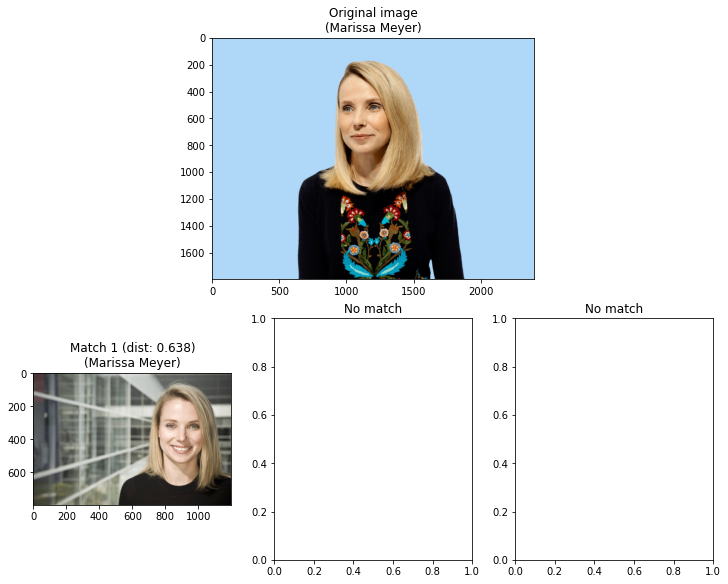


----------------------------------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

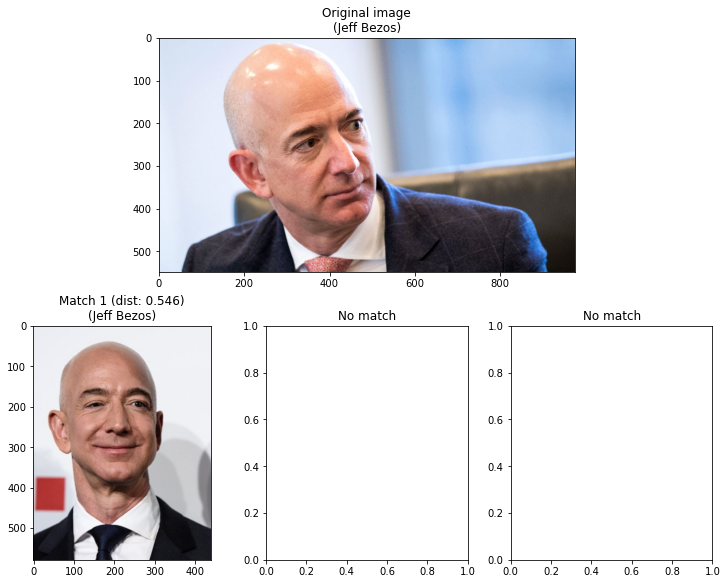


----------------------------------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

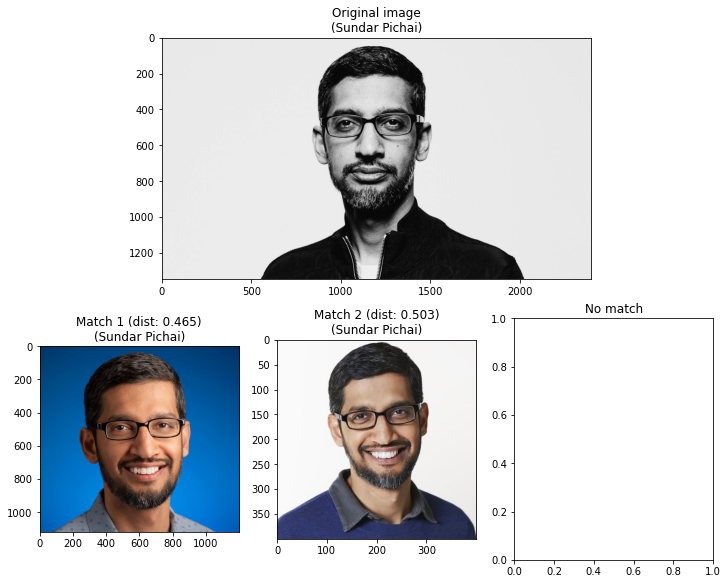


----------------------------------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

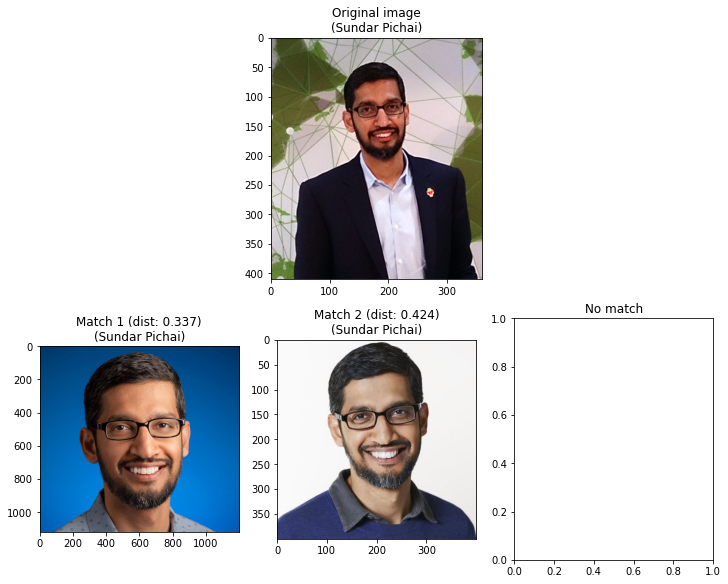


----------------------------------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

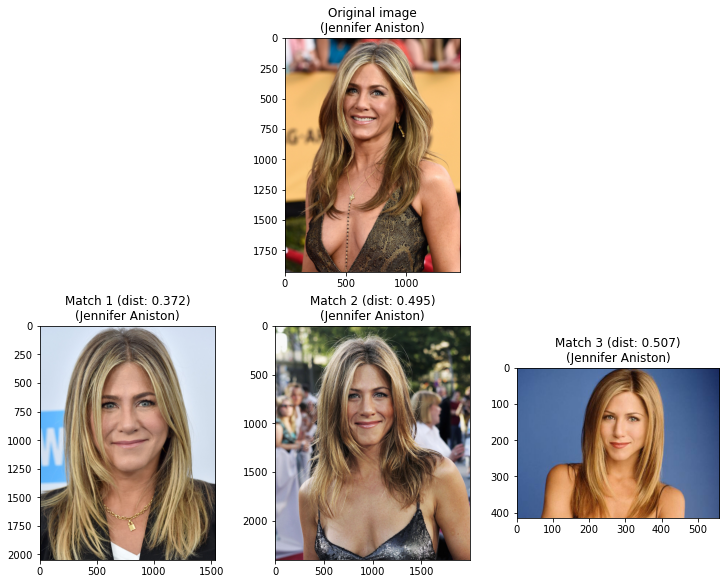


----------------------------------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

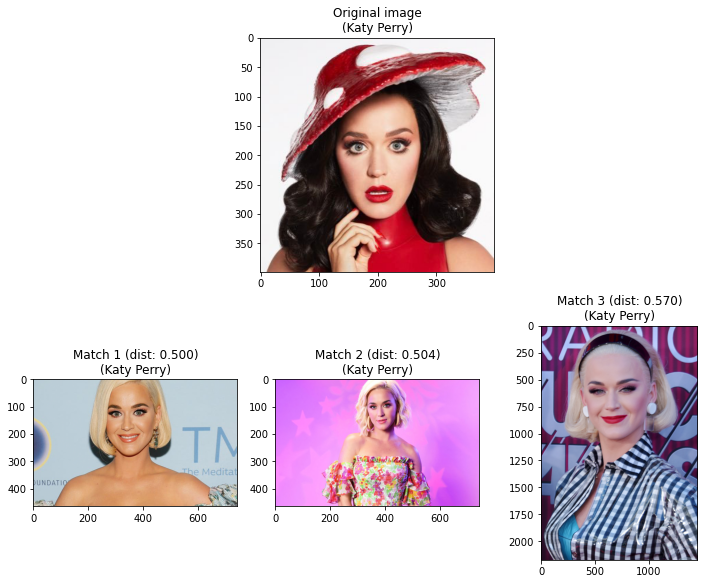


----------------------------------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

In [14]:
def plot_web_img_matches(img, matches, distances):
    """
    
    """
    # Creates a subplot mosaic
    axd = plt.figure(constrained_layout=True, figsize=(10, 8)).subplot_mosaic(
    """
    AAA
    BCD
    """
    );
    
    # Loops once per subplot (4 in total)
    for i, ax in zip(range(0, 4), axd.values()):
        # The first case is a special one as the original image is provided
        # as a numpy array
        if i == 0: 
            ax.imshow(img);
            ax.set_title(f'Original image\n({matches[0].name_tag})');
            
        # The image is obtained from the representation object in the following
        # cases
        else:
            # If there is a match, plot it
            if len(matches) >= i:
                ax.imshow(mpimg.imread(matches[i-1].image_fp));
                ax.set_title(f'Match {i} (dist: {distances[i-1]:.3f})\n' +
                             f'({matches[i-1].name_tag})');
                
            # Otherwise, just set the title to no match
            else:
                ax.set_title(f'No match');
        
    plt.show();
    
    return plt.gcf()
    
# ------------------------------------------------------------------------------

for img, match, similarity, tag in zip(web_imgs, matches, similarities, web_img_tags):
    fig = plot_web_img_matches(img, match, similarity['distances']);
    fig.suptitle(f'Web Image 1 ({tag}):', fontsize=14);
    print('\n', '-'*100, '\n', sep='')
    


Finally, we will investigate if there are considerable speed gains from using the Faiss library to reduce the database to a subset, and then perform exhaustive comparison. For that, we will **not** make use of the *do_verify_with_faiss* and *do_verify_without_faiss* functions, as they detect faces and calculate embeddings which technically belongs to the representation process and not the verification process.

In case this is a little confusing, recall that the verification process is calculating the similarity (distances) between a target embedding and a database of embeddings and determing the valid matches.

Since our dataset is considerable small (about 60 images), we will generate synthetic embeddings drawn from a Gaussian distribution. With that, we are emulating a database with 200 thousand embeddings. We will then compare the fourth embedding (belonging to an image of Jennifer Aniston) of the *tgt_embeddings* against it. 

In [33]:
# Creating synthetic embeddings and 'fake' database with 200 000 embeddings
start          = timer()
embedding_size = len(tgt_embeddings[4])
synth_embds    = []
j              = 0
for i in range(0, 200000): # 200k instances
    synth_embd = [random.gauss(-0.35, 0.48) for z in range(embedding_size)]
    synth_embds.append(synth_embd)
    
    if np.remainder(i, 20000) == 19999:
        j += 1
        print('{}% (took: {}s)'.format(j*10, timer()-start))
        start = timer()
    
synth_embds = np.array(synth_embds, dtype='f')

10% (took: 5.853846355006681s)
20% (took: 5.40828271900682s)
30% (took: 5.370852488995297s)
40% (took: 5.416484131004836s)
50% (took: 5.395384629002365s)
60% (took: 5.412558196003374s)
70% (took: 6.796439690006082s)
80% (took: 5.367642317003629s)
90% (took: 5.35205737400247s)
100% (took: 5.435049367006286s)


In [34]:
# Verifying with faiss - starting timer
wf_start = timer()

# Create the index required for verify_with_faiss
synth_index = create_faiss_index(synth_embds, metric=metric)

# Process target embedding for it to be compatible with faiss
processed_embd = np.array(tgt_embeddings[4], dtype='f')[None, :]

# Obtains the 'top_x' nearest neighbours
distances, neighbors = synth_index.search(processed_embd, top_x)

# If top_x is 1 then simply return the closest neighbour
if top_x == 1:
    wf_similarity_obj              = {}
    wf_similarity_obj['idxs']      = np.array(neighbors[0], dtype=int)
    wf_similarity_obj['threshold'] = -1
    wf_similarity_obj['distances'] = distances
else:
    # Obtains the embeddings for the 'filtered' (top_x) representations
    filtered_embds = []
    idxs           = []
    for i in neighbors[0]:
        filtered_embds.append(synth_embds[i, :])
        idxs.append(i)
    filtered_embds = np.array(filtered_embds)

    # Calculates the matches to the target embedding (from the top_x filtered
    # set of representations)
    wf_similarity_obj = calc_similarity(processed_embd, filtered_embds, metric=metric,
                                        model_name=chosen_model, threshold=threshold)

    # Note that the indexes returned in the similarity object refer to the
    # filtered representations. So the correct indexes (from the original
    # database) are actually the idxs[similarity_obj['idxs']]
    wf_similarity_obj['idxs'] = [idxs[i] for i in wf_similarity_obj['idxs']]

# End timer
wf_end = timer()

# Print results
wf_delta = wf_end - wf_start
print('Verification (with FAISS) took {:.3f} s (approx {} s / embedding)'.format(wf_delta, wf_delta / synth_embds.shape[0]))

Verification (with FAISS) took 1.005 s (approx 5.0235722800061925e-06 s / embedding)


In [35]:
# Verifying (without) no faiss - starting timer
nof_start = timer()

# Calculates the similarity between the current embedding and the
# database
nof_similarity_obj = calc_similarity(tgt_embeddings[4], synth_embds, metric=metric,
                                     model_name=chosen_model, threshold=threshold)
                                     
# End timer
nof_end = timer()

# Print results
nof_delta = nof_end - nof_start
print('Verification (with FAISS) took {:.3f} s (approx {} s / embedding)'.format(nof_delta, nof_delta / synth_embds.shape[0]))

Verification (with FAISS) took 0.266 s (approx 1.3298249750005197e-06 s / embedding)


As a last test, we will investigate if just using Faiss nearest neighbours is faster than the traditional, exhaustive comparison.

In [36]:
# Verifying using faiss nearest neighbour - starting timer
fnn_start = timer()

# Create the index required for verify_with_faiss
synth_index = create_faiss_index(synth_embds, metric=metric)

# Process target embedding for it to be compatible with faiss
processed_embd = np.array(tgt_embeddings[4], dtype='f')[None, :]

# Obtains the 'top_x' nearest neighbours
distances, neighbors = synth_index.search(processed_embd, top_x)

# End timer
fnn_end = timer()

# Print results
fnn_delta = fnn_end - fnn_start
print('Verification (nearest neighbour FAISS) took {:.3f} s (approx {} s / embedding)'.format(fnn_delta, fnn_delta / synth_embds.shape[0]))

Verification (nearest neighbour FAISS) took 0.761 s (approx 3.804561944998568e-06 s / embedding)


The results indicate that using faiss is actually slower than exhaustively calculating all distances and searching for the smallest ones. This is most likely due to the computational cost of calculating the faiss indexes.

As a reference for other experiments (using AWS Studio Lab with CPU):
 - WF : 1.005 s (approx 5.02e-06 s / embedding) for 200k embeddings
 - NOF: 0.266 s (approx 1.33e-06 s / embedding) for 200k embeddings
 - FNN: 0.761 s (approx 3.80e-06 s / embedding) for 200k embeddings